<a href="https://colab.research.google.com/github/Induwara24/Rose-Hearts/blob/main/Rose_Hearts_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get data from google drive
!gdown --id 1YxLmo9Nw5bLOGErfNkoWqUlEyWf2Rsq8

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1YxLmo9Nw5bLOGErfNkoWqUlEyWf2Rsq8
From (redirected): https://drive.google.com/uc?id=1YxLmo9Nw5bLOGErfNkoWqUlEyWf2Rsq8&confirm=t&uuid=36645279-ce26-46e9-86fb-623f55197169
To: /content/Mammogram_Dataset_KAU.zip
100% 606M/606M [00:10<00:00, 57.1MB/s]


In [3]:
# unzip the folder
!unzip /content/Mammogram_Dataset_KAU.zip

Archive:  /content/Mammogram_Dataset_KAU.zip
   creating: Mammogram_Dataset_KAU/
   creating: Mammogram_Dataset_KAU/Benign/
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC003026_ CC_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC003026_ CC_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC003026_ MLO_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC003026_ MLO_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC009941_ CC_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC009941_ CC_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC009941_ MLO_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC009941_ MLO_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC010562_ CC_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC010562_ CC_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC010562_ MLO_L.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC010562_ MLO_R.jpg  
  inflating: Mammogram_Dataset_KAU/Benign/2013_BC01118

In [4]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import shutil
import glob

In [5]:
# count the number of mammograms in the respective classes
ROOT_DIR = "/content/Mammogram_Dataset_KAU"
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Malignant', 124), ('Normal', 1865), ('Benign', 387)])

##Spliting the data;
- 70% for train data
- 15% for test data
- 15% for validation data

In [6]:
# create a function to split the data into separate folders
def splitDataFolder(path, split):

  if not os.path.exists("./"+path):
    os.mkdir("./"+path)

  for dir in os.listdir(ROOT_DIR):
    os.makedirs("./"+path+"/"+dir)
    for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir)), size=math.floor(split*number_of_images[dir]), replace=False):
      O = os.path.join(ROOT_DIR, dir, img)
      D = os.path.join("./"+path, dir)
      shutil.copy(O, D)
      os.remove(O)

  else:
    print(f"{path} folder already exists.")

In [7]:
# create the train folder
splitDataFolder("train", 0.7)

train folder already exists.


In [8]:
# create the validation folder
splitDataFolder("val", 0.15)

val folder already exists.


In [9]:
# create the test folder
splitDataFolder("test", 0.15)

test folder already exists.


###Preparing the data using Data Generator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

In [11]:
# create function to preprocess images
def preprocessingImages1(path):
  """
  input: path to the folder
  output: preprocessed images
  """
  # data augmentation
  image_data = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )
  image = image_data.flow_from_directory(
      directory=path,
      target_size=(224,224),
      batch_size=32,
      class_mode="categorical"
  )
  return image

In [12]:
# preprocess train data
path = "/content/train"
train_data = preprocessingImages1(path)

Found 1661 images belonging to 3 classes.


In [13]:
# create function to preprocess images
def preprocessingImages2(path):
  """
  input: path to the folder
  output: preprocessed images
  """
  image_data = ImageDataGenerator(
      preprocessing_function=preprocess_input
  )
  image = image_data.flow_from_directory(
      directory=path,
      target_size=(224,224),
      batch_size=32,
      class_mode="categorical"
  )
  return image

In [14]:
# preprocess test data
path = "/content/test"
test_data = preprocessingImages2(path)

Found 355 images belonging to 3 classes.


In [15]:
# preprocess validation data
path = "/content/val"
val_data = preprocessingImages2(path)

Found 355 images belonging to 3 classes.


# Model build

In [16]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet
import tensorflow as tf

In [17]:
# create the functional model
base_model = MobileNet(input_shape=(224,224,3), include_top=False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# make sure the model is not re trained again
for layer in base_model.layers:
  layer.trainable = False

In [19]:
# summary of the base model
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [20]:
# combining our custom layer with the base model
x = Flatten()(base_model.output)
x = Dense(units=3, activation="softmax")(x)

In [21]:
# create the model
model = Model(base_model.input, x)

In [22]:
# summary of the custom model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,379,395 (12.89 MB)

 Trainable params: 150,531 (588.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

- Flatten layer and Dense layer are added to the bottom

In [23]:
#compile the model
model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])

In [24]:
# early stopping and model checkpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

mc = ModelCheckpoint(filepath="./best_model.h5", monitor="val_accuracy", verbose=1, save_best_only=True)
es = EarlyStopping(monitor="val_accuracy",  min_delta=0.01, verbose=1, patience=3)

cb = [es, mc]

## Model training

In [25]:
hs = model.fit(
    train_data, # Changed 'generator' to directly use train_data
    steps_per_epoch=8,
    epochs=30,
    validation_data=val_data,
    validation_steps=16,
    callbacks=cb
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5712 - loss: 5.1917
Epoch 1: val_accuracy improved from -inf to 0.82817, saving model to ./best_model.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5863 - loss: 5.2430 - val_accuracy: 0.8282 - val_loss: 3.3399
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8204 - loss: 3.2860
Epoch 2: val_accuracy did not improve from 0.82817
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8195 - loss: 3.2737 - val_accuracy: 0.8254 - val_loss: 2.9622
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.8612 - loss: 3.3601
Epoch 3: val_accuracy did not improve from 0.82817
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8584 - loss: 3.3450 - val_accuracy: 0.7859 - val_loss: 3.2952
Epoch 4/30
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8233 - loss: 2.8513
Epoch 4: val_accuracy did not improve from 0.82817
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8261 - loss: 2.7097 - val_accuracy: 0.8225 - val_loss: 3.0676
Epoch 4: early stopping


## Model accuracy


In [26]:
# load the best fit model
from keras.models import load_model
model = load_model("/content/best_model.h5")

In [27]:
# Model accuracy
accuracy = model.evaluate(test_data)[1]
print(f"Test Accuracy: {round(accuracy*100, 2)}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 904ms/step - accuracy: 0.8262 - loss: 2.8687
Test Accuracy: 81.69%


## Model graphical interpretation

In [28]:
h = hs.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

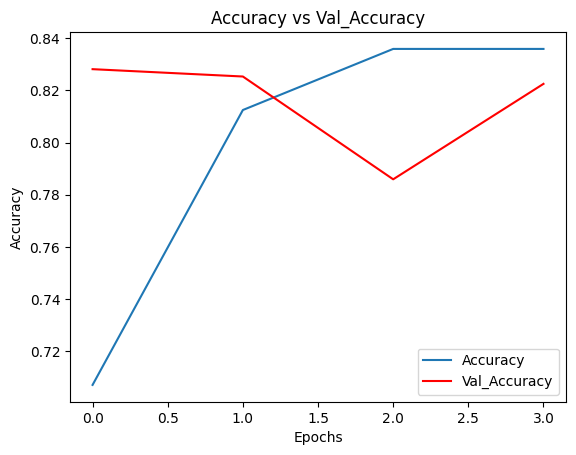

In [29]:
# graph of accuracy vs val_accuracy
plt.plot(h["accuracy"])
plt.plot(h["val_accuracy"], c = "red")
plt.title("Accuracy vs Val_Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Val_Accuracy"])
plt.show()

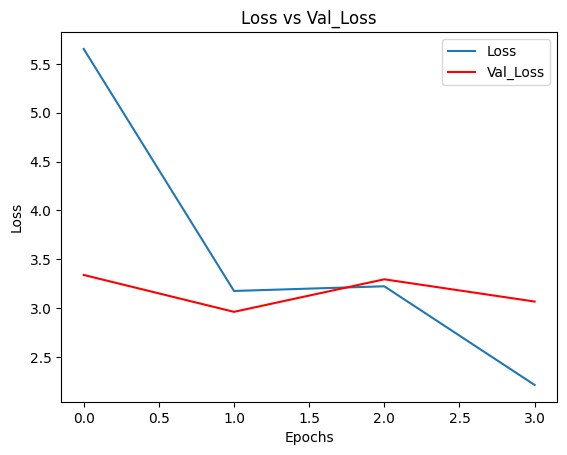

In [30]:
# graph of loss vs val_loss
plt.plot(h["loss"])
plt.plot(h["val_loss"], c = "red")
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Val_Loss"])
plt.show()

## Test the model with mammogram images

In [31]:
train_data.class_indices

{'Benign': 0, 'Malignant': 1, 'Normal': 2}

In [32]:
from keras.preprocessing.image import load_img, img_to_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Normal


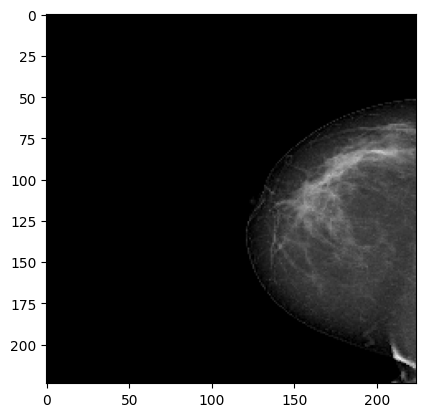

In [34]:
path = "/content/Mammogram_Dataset_KAU/Normal/2018_BC008361_ CC_R.jpg"
img = load_img(path, target_size=(224,224))

i = img_to_array(img)/255

input_arr = np.expand_dims(i, axis=0)
# Get the prediction probabilities using 'predict'
pred_probs = model.predict(input_arr)
# Get the class with the highest probability using argmax
pred = np.argmax(pred_probs, axis=1)
pred

if pred == 0:
  print("Prediction: Benign")
elif pred == 1:
  print("Prediction: Malignant")
else:
  print("Prediction: Normal")

# display the image
plt.imshow(input_arr[0])
plt.show()